In [484]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder

In [485]:
train_df = pd.read_csv('./titanic/train.csv')#-890
test_df = pd.read_csv('./titanic/test.csv')#891-


data_df = train_df.append(test_df)

/var/folders/rl/pyfz32cs4rq01p8c57cwqj6m0000gn/T/ipykernel_29764/1347016715.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = train_df.append(test_df)


In [486]:
data_df.head()

PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [487]:
def preprocess_data(data_df):

    # Sex 
    data_df['male'] = (data_df['Sex'] == 'male').astype('int32')
    data_df['female'] = (data_df['Sex'] == 'female').astype('int32')

    # Family size
    data_df['FamilySize'] = data_df['Parch'] + data_df['SibSp'] + 1
    data_df['IsAlone'] = (data_df['FamilySize'] == 1).astype('int32')
    data_df['HasSmallFamily'] = data_df['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    data_df['HasBigFamily'] = data_df['FamilySize'].map(lambda s: 1 if 5 <= s else 0) # Requires further manipulations

    # Family name
    data_df['FamilyName'] = data_df['Name'].str.extract('(\w+),', expand=False)
    data_df['NameLength'] = data_df['Name'].apply(lambda x: len(x)) #high-borns have longer names on average

    # Title
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)

    title_mappings = {
        'Mlle': 'Miss',
        'Miss': 'Miss',
        'Mrs': 'Woman',
        'Ms': 'Woman', 
        'Mme': 'Woman',
        'Dona': 'High-born',
        'Lady': 'High-born', 
        'Capt': 'Army', 
        'Countess': 'High-born', 
        'Major': 'Army', 
        'Col': 'Army', 
        'Sir': 'High-born', 
        'Don': 'High-born',
        'Jonkheer': 'High-born', 
        'Rev': 'Army',
        'Dr': 'Army',
        'Master': 'Boy' # for boy and young men
    }

    data_df['SocialLayer'] = data_df['Title'].replace(title_mappings)
    data_df['SocialLayerCodes'] = LabelEncoder().fit_transform(data_df['SocialLayer'])

    data_df['IsArmy'] = (data_df['SocialLayer'] == 'Army').astype('int32')
    data_df['IsBoy'] = (data_df['SocialLayer'] == 'Boy').astype('int32')
    data_df['IsHigh-born'] = (data_df['SocialLayer'] == 'High-born').astype('int32')

    titles = list(data_df['Title'].unique())

    # Missing age is median grouped by titles
    for title in titles:
        data_df.loc[data_df['Age'].isnull() & data_df['Title'] == title, 'Age'] = data_df.groupby('Title')['Age'].median()[title]

    # fill other NaNs with global median
    data_df['Age'].fillna(data_df['Age'].median(), inplace=True)
    data_df['IsAdult'] = (data_df['Age'] >= 18).astype('int32')

    # Missing fare is average grouped by titles
    for title in titles:
        data_df.loc[data_df['Fare'].isnull() & data_df['Title'] == title, 'Fare'] = data_df.groupby('Title')['Fare'].mean()[title]

    # fill other Nans with global mean
    data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

    # Represent Fare as intervals
    data_df['FareBin'] = pd.qcut(data_df['Fare'], 5, duplicates='drop')
    data_df['FareBinInterval']= LabelEncoder().fit_transform(data_df['FareBin'])

    # same goes for Age
    data_df['AgeBin'] = pd.qcut(data_df['Age'], 5, duplicates='drop')
    data_df['AgeBinInterval']= LabelEncoder().fit_transform(data_df['AgeBin'])

    # Cabin
    data_df['CabinPrefix'] = data_df.Cabin.str.get(0).fillna('Z')
    data_df['HasCabin'] = (data_df['CabinPrefix'] != 'Z').astype('int32')


    names = list(data_df['FamilyName'].unique())

    for name in names:

        mask1 = (data_df['FamilyName'] == name) & (data_df['Sex'] == 'male') & (data_df['IsAdult'] == 1)
        people_to_help = data_df[mask1].shape[0]
        mask2 = (data_df['FamilyName'] == name) & ( (data_df['Sex'] == 'female') | (data_df['IsAdult'] == 0) )
        data_df.loc[mask2, 'PeopleToHelp(Family)'] = int(people_to_help)


    data_df['PeopleToHelp(Family)'].fillna(0, inplace=True)

    tickets = list(data_df['Ticket'].unique())

    for ticket in tickets:

        mask1 = (data_df['Ticket'] == ticket) & (data_df['Sex'] == 'male') & (data_df['IsAdult'] == 1)
        people_to_help = data_df[mask1].shape[0]
        mask2 = (data_df['Ticket'] == ticket) & ( (data_df['Sex'] == 'female') | (data_df['IsAdult'] == 0) )
        data_df.loc[mask2, 'PeopleToHelp(Ticket)'] = int(people_to_help)


    data_df['PeopleToHelp(Ticket)'].fillna(0, inplace=True)


In [488]:
preprocess_data(data_df)

In [489]:
import seaborn as sns
from matplotlib import pyplot as plt

def plot_data(data_df, x, y, hue=None):
    fig, ax = plt.subplots(figsize=(15,5))
    ax = sns.barplot(x=x, y=y, data=data_df, hue=hue)
    plt.xticks(rotation=0)
    plt.title(f'Percentage of {y} by {x}')
    plt.show()

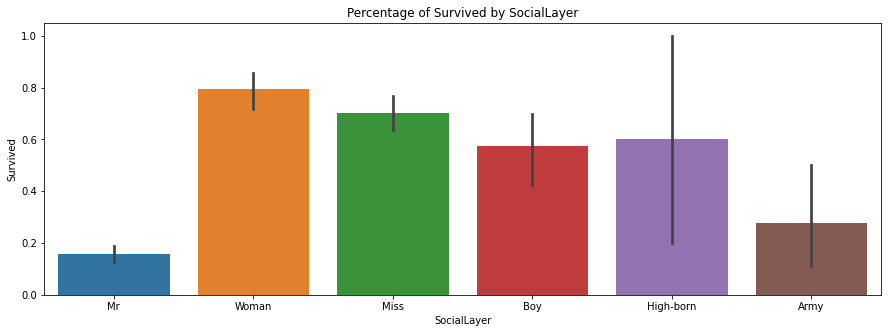

In [490]:
plot_data(data_df, 'SocialLayer', 'Survived') # Probably men and army will die to save women, children and high-born

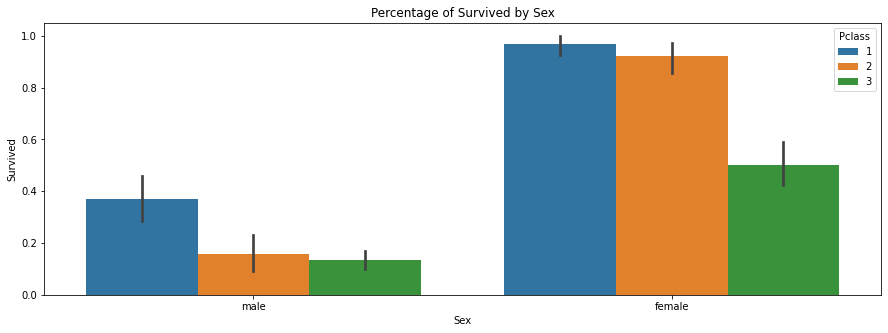

In [491]:
plot_data(data_df, 'Sex', 'Survived', 'Pclass') #Pclass doesn't change that much

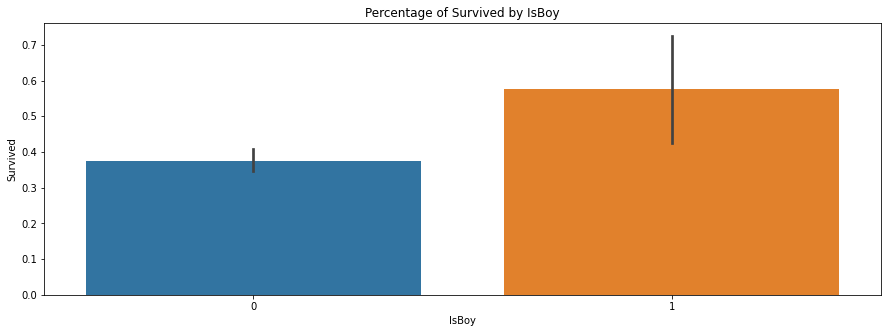

In [492]:
plot_data(data_df, 'IsBoy', 'Survived')

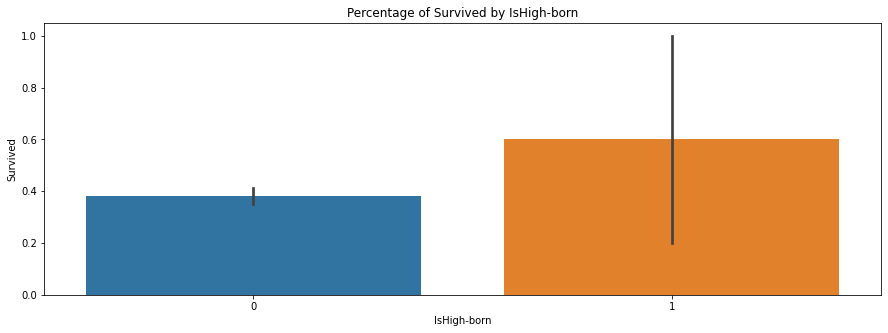

In [493]:
plot_data(data_df, 'IsHigh-born', 'Survived')

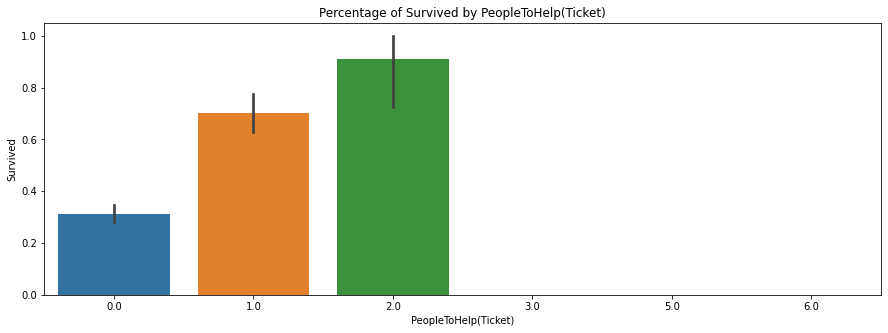

In [494]:
plot_data(data_df, 'PeopleToHelp(Ticket)', 'Survived')

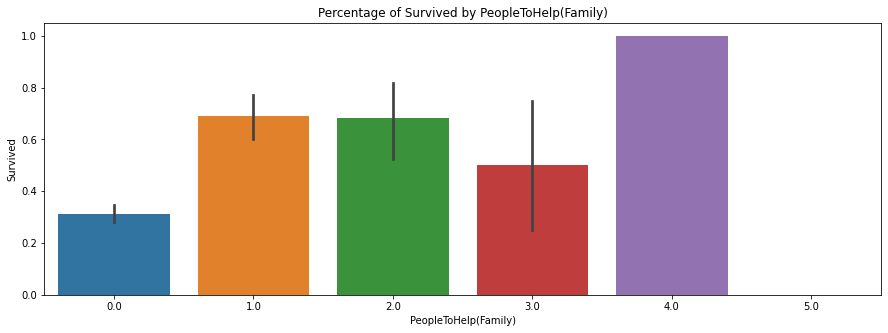

In [495]:
plot_data(data_df, 'PeopleToHelp(Family)', 'Survived')

In [496]:
data_df

PassengerId  Survived  Pclass  \
0              1       0.0       3   
1              2       1.0       1   
2              3       1.0       3   
3              4       1.0       1   
4              5       0.0       3   
..           ...       ...     ...   
413         1305       NaN       3   
414         1306       NaN       1   
415         1307       NaN       3   
416         1308       NaN       3   
417         1309       NaN       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
413                                 Spector, Mr. Woolf    male  28.0      0   
414                       Oliva y Ocana, Dona. Fermina  female  39.0      0   
415                       Saether, Mr. Simon Sivertsen    male  38.5      0   
416                                Ware, Mr. Frederick    male  28.0      0   
417                           Peter, Master. Michael J    male  28.0      1   

     Parch              Ticket      Fare  ... IsHigh-born IsAdult  \
0        0           A/5 21171    7.2500  ...           0       1   
1        0            PC 17599   71.2833  ...           0       1   
2        0    STON/O2. 3101282    7.9250  ...           0       1   
3        0              113803   53.1000  ...           0       1   
4        0              373450    8.0500  ...           0       1   
..     ...                 ...       ...  ...         ...     ...   
413      0           A.5. 3236    8.0500  ...           0       1   
414      0            PC 17758  108.9000  ...           1       1   
415      0  SOTON/O.Q. 3101262    7.2500  ...           0       1   
416      0              359309    8.0500  ...           0       1   
417      1                2668   22.3583  ...           0       1   

               FareBin  FareBinInterval        AgeBin  AgeBinInterval  \
0      (-0.001, 7.854]                0  (21.0, 28.0]               1   
1    (41.579, 512.329]                4  (28.0, 39.0]               2   
2        (7.854, 10.5]                1  (21.0, 28.0]               1   
3    (41.579, 512.329]                4  (28.0, 39.0]               2   
4        (7.854, 10.5]                1  (28.0, 39.0]               2   
..                 ...              ...           ...             ...   
413      (7.854, 10.5]                1  (21.0, 28.0]               1   
414  (41.579, 512.329]                4  (28.0, 39.0]               2   
415    (-0.001, 7.854]                0  (28.0, 39.0]               2   
416      (7.854, 10.5]                1  (21.0, 28.0]               1   
417   (21.679, 41.579]                3  (21.0, 28.0]               1   

     CabinPrefix  HasCabin PeopleToHelp(Family)  PeopleToHelp(Ticket)  
0              Z         0                  0.0                   0.0  
1              C         1                  1.0                   1.0  
2              Z         0                  0.0                   0.0  
3              C         1                  1.0                   1.0  
4              Z         0                  0.0                   0.0  
..           ...       ...                  ...                   ...  
413            Z         0                  0.0                   0.0  
414            C         1                  0.0                   1.0  
415            Z         0                  0.0                   0.0  
416            Z         0                  0.0                   0.0  
417            Z         0                  0.0                   0.0  

[1309 rows x 35 columns]

In [497]:
#Drop unnecessary columns

passengerIds = data_df['PassengerId'].copy()
data_df.drop(['PassengerId', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'FareBin', 'AgeBin', 'CabinPrefix', 'HasCabin', 'Cabin', 'Embarked', 'Title', 'SocialLayer', 'FamilyName'], axis=1, inplace=True)
data_df



Survived      Fare  male  female  FamilySize  IsAlone  HasSmallFamily  \
0         0.0    7.2500     1       0           2        0               1   
1         1.0   71.2833     0       1           2        0               1   
2         1.0    7.9250     0       1           1        1               0   
3         1.0   53.1000     0       1           2        0               1   
4         0.0    8.0500     1       0           1        1               0   
..        ...       ...   ...     ...         ...      ...             ...   
413       NaN    8.0500     1       0           1        1               0   
414       NaN  108.9000     0       1           1        1               0   
415       NaN    7.2500     1       0           1        1               0   
416       NaN    8.0500     1       0           1        1               0   
417       NaN   22.3583     1       0           3        0               1   

     HasBigFamily  NameLength  SocialLayerCodes  IsArmy  IsBoy  IsHigh-born  \
0               0          23                 4       0      0            0   
1               0          51                 5       0      0            0   
2               0          22                 3       0      0            0   
3               0          44                 5       0      0            0   
4               0          24                 4       0      0            0   
..            ...         ...               ...     ...    ...          ...   
413             0          18                 4       0      0            0   
414             0          28                 2       0      0            1   
415             0          28                 4       0      0            0   
416             0          19                 4       0      0            0   
417             0          24                 1       0      1            0   

     IsAdult  FareBinInterval  AgeBinInterval  PeopleToHelp(Family)  \
0          1                0               1                   0.0   
1          1                4               2                   1.0   
2          1                1               1                   0.0   
3          1                4               2                   1.0   
4          1                1               2                   0.0   
..       ...              ...             ...                   ...   
413        1                1               1                   0.0   
414        1                4               2                   0.0   
415        1                0               2                   0.0   
416        1                1               1                   0.0   
417        1                3               1                   0.0   

     PeopleToHelp(Ticket)  
0                     0.0  
1                     1.0  
2                     0.0  
3                     1.0  
4                     0.0  
..                    ...  
413                   0.0  
414                   1.0  
415                   0.0  
416                   0.0  
417                   0.0  

[1309 rows x 18 columns]

In [498]:

train_df = data_df[:891]
test_df = data_df[891:]

In [499]:
train_df

Survived     Fare  male  female  FamilySize  IsAlone  HasSmallFamily  \
0         0.0   7.2500     1       0           2        0               1   
1         1.0  71.2833     0       1           2        0               1   
2         1.0   7.9250     0       1           1        1               0   
3         1.0  53.1000     0       1           2        0               1   
4         0.0   8.0500     1       0           1        1               0   
..        ...      ...   ...     ...         ...      ...             ...   
886       0.0  13.0000     1       0           1        1               0   
887       1.0  30.0000     0       1           1        1               0   
888       0.0  23.4500     0       1           4        0               1   
889       1.0  30.0000     1       0           1        1               0   
890       0.0   7.7500     1       0           1        1               0   

     HasBigFamily  NameLength  SocialLayerCodes  IsArmy  IsBoy  IsHigh-born  \
0               0          23                 4       0      0            0   
1               0          51                 5       0      0            0   
2               0          22                 3       0      0            0   
3               0          44                 5       0      0            0   
4               0          24                 4       0      0            0   
..            ...         ...               ...     ...    ...          ...   
886             0          21                 0       1      0            0   
887             0          28                 3       0      0            0   
888             0          40                 3       0      0            0   
889             0          21                 4       0      0            0   
890             0          19                 4       0      0            0   

     IsAdult  FareBinInterval  AgeBinInterval  PeopleToHelp(Family)  \
0          1                0               1                   0.0   
1          1                4               2                   1.0   
2          1                1               1                   0.0   
3          1                4               2                   1.0   
4          1                1               2                   0.0   
..       ...              ...             ...                   ...   
886        1                2               1                   0.0   
887        1                3               0                   1.0   
888        1                3               1                   2.0   
889        1                3               1                   0.0   
890        1                0               2                   0.0   

     PeopleToHelp(Ticket)  
0                     0.0  
1                     1.0  
2                     0.0  
3                     1.0  
4                     0.0  
..                    ...  
886                   0.0  
887                   0.0  
888                   2.0  
889                   0.0  
890                   0.0  

[891 rows x 18 columns]

In [500]:
test_df

Survived      Fare  male  female  FamilySize  IsAlone  HasSmallFamily  \
0         NaN    7.8292     1       0           1        1               0   
1         NaN    7.0000     0       1           2        0               1   
2         NaN    9.6875     1       0           1        1               0   
3         NaN    8.6625     1       0           1        1               0   
4         NaN   12.2875     0       1           3        0               1   
..        ...       ...   ...     ...         ...      ...             ...   
413       NaN    8.0500     1       0           1        1               0   
414       NaN  108.9000     0       1           1        1               0   
415       NaN    7.2500     1       0           1        1               0   
416       NaN    8.0500     1       0           1        1               0   
417       NaN   22.3583     1       0           3        0               1   

     HasBigFamily  NameLength  SocialLayerCodes  IsArmy  IsBoy  IsHigh-born  \
0               0          16                 4       0      0            0   
1               0          32                 5       0      0            0   
2               0          25                 4       0      0            0   
3               0          16                 4       0      0            0   
4               0          44                 5       0      0            0   
..            ...         ...               ...     ...    ...          ...   
413             0          18                 4       0      0            0   
414             0          28                 2       0      0            1   
415             0          28                 4       0      0            0   
416             0          19                 4       0      0            0   
417             0          24                 1       0      1            0   

     IsAdult  FareBinInterval  AgeBinInterval  PeopleToHelp(Family)  \
0          1                0               2                   0.0   
1          1                0               3                   0.0   
2          1                1               3                   0.0   
3          1                1               1                   0.0   
4          1                2               1                   0.0   
..       ...              ...             ...                   ...   
413        1                1               1                   0.0   
414        1                4               2                   0.0   
415        1                0               2                   0.0   
416        1                1               1                   0.0   
417        1                3               1                   0.0   

     PeopleToHelp(Ticket)  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
..                    ...  
413                   0.0  
414                   1.0  
415                   0.0  
416                   0.0  
417                   0.0  

[418 rows x 18 columns]

In [501]:
X_train = train_df
y_train = train_df['Survived'].copy()

X_train.drop(['Survived'], axis=1, inplace=True)


X_test = test_df.drop('Survived', axis=1)

/var/folders/rl/pyfz32cs4rq01p8c57cwqj6m0000gn/T/ipykernel_29764/2445955270.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['Survived'], axis=1, inplace=True)


In [502]:
# scale data

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [505]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=0)

param_grid = {
    'n_neighbors': [n for n in range(1, 30)],
    'algorithm': ['auto'],
    'leaf_size': [n for n in range(1, 50, 5)],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [2]
}

grid_KNN = GridSearchCV(KNeighborsClassifier(), param_grid = param_grid, cv=cv, scoring = 'roc_auc', refit=True, verbose=10)
grid_KNN.fit(X_train_scaled, y_train)

print(grid_KNN.best_score_)
print(grid_KNN.best_estimator_)#leaf_size=1, n_neighbors=10

y_pred_KNN = grid_KNN.predict(X_test_scaled)


Fitting 20 folds for each of 580 candidates, totalling 11600 fits
[CV 1/20; 1/580] START algorithm=auto, leaf_size=1, metric=minkowski, n_neighbors=1, p=2, weights=uniform
[CV 1/20; 1/580] END algorithm=auto, leaf_size=1, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.764 total time=   0.1s
[CV 2/20; 1/580] START algorithm=auto, leaf_size=1, metric=minkowski, n_neighbors=1, p=2, weights=uniform
[CV 2/20; 1/580] END algorithm=auto, leaf_size=1, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.894 total time=   0.0s
[CV 3/20; 1/580] START algorithm=auto, leaf_size=1, metric=minkowski, n_neighbors=1, p=2, weights=uniform
[CV 3/20; 1/580] END algorithm=auto, leaf_size=1, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.692 total time=   0.0s
[CV 4/20; 1/580] START algorithm=auto, leaf_size=1, metric=minkowski, n_neighbors=1, p=2, weights=uniform
[CV 4/20; 1/580] END algorithm=auto, leaf_size=1, metric=minkowski, n_neighbors=1, p=2, weights=uni

In [508]:
#XGBOOST
from xgboost import XGBClassifier
from scipy.stats.distributions import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

param_distributions = {
    'max_depth': randint(3, 11),
    'learning_rate': uniform(0.001, 0.1-0.001),
    'n_estimators': randint(10, 400),
    'gamma': uniform(0,2),
    'colsample_bytree': uniform(0.5, 0.5),
    'subsample': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 11)
}

grid_XGB = RandomizedSearchCV(XGBClassifier(), param_distributions = param_distributions, cv=cv, scoring='roc_auc', refit=True, n_iter=500, verbose=10)
grid_XGB.fit(X_train_scaled, y_train)
print(grid_XGB.best_score_)
print(grid_XGB.best_estimator_)#{'colsample_bytree': 0.5779298926333951, 'gamma': 0.830192677524501, 'learning_rate': 0.09820333840195299, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 16, 'subsample': 0.8652319080511046}


y_pred_XGB = grid_XGB.predict(X_test_scaled)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5; 1/500] START colsample_bytree=0.6407452391933646, gamma=0.36069305051509204, learning_rate=0.08784271987710943, max_depth=9, min_child_weight=10, n_estimators=228, subsample=0.7186288252229394
[CV 1/5; 1/500] END colsample_bytree=0.6407452391933646, gamma=0.36069305051509204, learning_rate=0.08784271987710943, max_depth=9, min_child_weight=10, n_estimators=228, subsample=0.7186288252229394;, score=0.877 total time=   0.3s
[CV 2/5; 1/500] START colsample_bytree=0.6407452391933646, gamma=0.36069305051509204, learning_rate=0.08784271987710943, max_depth=9, min_child_weight=10, n_estimators=228, subsample=0.7186288252229394
[CV 2/5; 1/500] END colsample_bytree=0.6407452391933646, gamma=0.36069305051509204, learning_rate=0.08784271987710943, max_depth=9, min_child_weight=10, n_estimators=228, subsample=0.7186288252229394;, score=0.897 total time=   0.3s
[CV 3/5; 1/500] START colsample_bytree=0.6407452391933646, gamma=0

In [511]:
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga', 'sag'],
    'C': [10**n for n in range(-5,5)],
    'max_iter': [200]
}

grid_LR = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv, scoring = 'roc_auc', refit=True, verbose=10)

grid_LR.fit(X_train_scaled, y_train)
print(grid_LR.best_score_)
print(grid_LR.best_estimator_)#C=1, max_iter=200, solver='newton-cg'


y_pred_LR= grid_LR.predict(X_test_scaled)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START C=1e-05, max_iter=200, solver=newton-cg....................
[CV 1/5; 1/50] END C=1e-05, max_iter=200, solver=newton-cg;, score=0.872 total time=   0.1s
[CV 2/5; 1/50] START C=1e-05, max_iter=200, solver=newton-cg....................
[CV 2/5; 1/50] END C=1e-05, max_iter=200, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 3/5; 1/50] START C=1e-05, max_iter=200, solver=newton-cg....................
[CV 3/5; 1/50] END C=1e-05, max_iter=200, solver=newton-cg;, score=0.857 total time=   0.0s
[CV 4/5; 1/50] START C=1e-05, max_iter=200, solver=newton-cg....................
[CV 4/5; 1/50] END C=1e-05, max_iter=200, solver=newton-cg;, score=0.800 total time=   0.0s
[CV 5/5; 1/50] START C=1e-05, max_iter=200, solver=newton-cg....................
[CV 5/5; 1/50] END C=1e-05, max_iter=200, solver=newton-cg;, score=0.716 total time=   0.0s
[CV 1/5; 2/50] START C=1e-05, max_iter=200, solver=lbfgs.................

In [513]:
from sklearn.ensemble import VotingClassifier

clf1 = XGBClassifier(**{'colsample_bytree': 0.5779298926333951, 'gamma': 0.830192677524501, 'learning_rate': 0.09820333840195299, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 16, 'subsample': 0.8652319080511046})
clf2 = KNeighborsClassifier(leaf_size=1, n_neighbors=10)
clf3 = LogisticRegression(C=1, max_iter=200, solver='newton-cg')

voting_clf = VotingClassifier(
    estimators=[('XGBClassifier', clf1), ('KNeighborsClassifier', clf2), ('LogisticRegression', clf3)],
    voting='hard'
)

voting_clf.fit(X_train_scaled, y_train)

y_pred_voting = voting_clf.predict(X_test_scaled)



In [515]:
y_pred_voting = y_pred_voting.astype(int)
y_pred_voting

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [516]:
submission = pd.DataFrame({ 'PassengerId': passengerIds[891:],
                            'Survived': y_pred_voting })
submission.to_csv("VOTING_SUBMISSION.csv", index=False)

In [519]:
submission = pd.DataFrame({ 'PassengerId': passengerIds[891:],
                            'Survived': y_pred_LR.astype(int) })
submission.to_csv("LR_SUBMISSION.csv", index=False)